In [1]:
import json
import streamlit as st
from dotenv import load_dotenv
from pydantic import BaseModel, Field
from typing import List, Annotated, Literal, Dict, Callable, TypeVar, Tuple, Type, Generic, Optional, Union, Any
from typing_extensions import TypedDict 

# LangChain 및 LangGraph 관련 라이브러리
from langchain.prompts.chat import ChatPromptTemplate, MessagesPlaceholder
from langchain_core.output_parsers import StrOutputParser
from langchain_core.messages import HumanMessage, AIMessage

from langgraph.types import Command
from langgraph.graph.message import add_messages
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import create_react_agent
from langsmith import utils 
from datetime import datetime, timedelta
from langchain_openai import ChatOpenAI

from agents.agent_library import agent_configs
from team_graph.report_team_subgraph import report_graph
from team_graph.general_chat_subgraph import general_graph
from team_graph.insider_team_graph import insider_graph 
# 환경 변수 로드
load_dotenv()
print(utils.tracing_is_enabled())

True


In [2]:
class AgentState(MessagesState):
    query: str


In [3]:
llm = ChatOpenAI(model="gpt-4o-mini-2024-07-18")

In [4]:
# 시장 조사 에이전트
news_and_sentiment_retrieval_agent = create_react_agent(
    llm, 
    tools=agent_configs['news_and_sentiment_retrieval_agent']['tools'],
    prompt=agent_configs['news_and_sentiment_retrieval_agent']['prompt']
)

market_data_retrieval_agent = create_react_agent(
    llm, 
    tools=agent_configs['market_data_retrieval_agent']['tools'], 
    prompt = agent_configs['market_data_retrieval_agent']['prompt']
)


economic_data_retrieval_agent = create_react_agent(
    llm, 
    tools=agent_configs['economic_data_retrieval_agent']['tools'], 
    prompt=agent_configs['economic_data_retrieval_agent']['prompt']
)


financial_statement_retrieval_agent = create_react_agent(
    llm,
    tools=agent_configs['financial_statement_retrieval_agent']['tools'],
    prompt = agent_configs['financial_statement_retrieval_agent']['prompt']
)


data_retrieval_team_members=agent_configs['data_retrieval_leader_agent']['members']
data_retrieval_options_for_next = data_retrieval_team_members + ["FINISH"]
data_retrieval_leader_system_prompt = agent_configs['data_retrieval_leader_agent']['prompt']
data_retrieval_leader_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", data_retrieval_leader_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}. "
            "Return a JSON with 'next', 'is_vague', and optionally 'response' if vague. "
            "If not vague and no clarification is needed, leave 'response' empty."
        ),
    ]
).partial(options=str(data_retrieval_options_for_next), members=", ".join(data_retrieval_team_members))


data_cleansing_system_prompt = agent_configs['data_cleansing_agent']['prompt']
data_cleansing_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", data_cleansing_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, "
            "Refine and process this data to align with the user's original question : {query}"
        )
    ]
)

supervisor_members = agent_configs['supervisor']['members']
supervisor_options_for_next = supervisor_members + ["FINISH"]
supervisor_system_prompt = agent_configs['supervisor']['prompt']
supervisor_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", supervisor_system_prompt),
        MessagesPlaceholder(variable_name="messages"),
        (
            "system",
            "Given the conversation above, who should act next? "
            "Or should we FINISH? Select one of: {options}",
        ),
    ]
).partial(options=str(supervisor_options_for_next), members=", ".join(supervisor_members))


In [5]:
def news_and_sentiment_retrieval_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    금융 뉴스 및 애널리스트 의견 수집

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    # 시장 조사 에이전트를 호출하여 결과를 얻습니다.
    result = news_and_sentiment_retrieval_agent.invoke(state)
    
    # 결과 메시지를 업데이트하고 supervisor node로 이동합니다.
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='news_and_sentiment_retrieval')]},
        goto='data_retrieval_leader'
    )



In [6]:
def market_data_retrieval_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    실시간 주가 및 거래량 수집
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = market_data_retrieval_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='market_data_retrieval')]},
        goto='data_retrieval_leader'
    )

In [7]:
def economic_data_retrieval_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    거시경제 데이터(GDP, 금리, 인플레이션) 수집
    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor node로 이동하기 위한 명령을 반환
    """
    result = economic_data_retrieval_agent.invoke(state)

    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='economic_data_retrieval')]},
        goto='data_retrieval_leader'
    )

In [8]:
def financial_statement_retrieval_node(state: AgentState) -> Command[Literal["data_retrieval_leader"]]:
    """
    회사 재무 보고서와 주요 사건 관련 자료를 조사하는 노드.
    손익계산서 데이터와 재무 및 주요 사건 관련 SEC 보고서를 처리합니다.

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: supervisor 노드로 이동하기 위한 명령을 반환
    """
    result = financial_statement_retrieval_agent.invoke(state)
    return Command(
        update={'messages': [HumanMessage(content=result['messages'][-1].content, name='financial_statement_retrieval')]},
        goto='data_retrieval_leader'
    )


In [10]:
class DataTeamRouter(TypedDict):
    """Worker to route to next. If no workers needed or question is vague, route to FINISH."""
    next: Literal[*data_retrieval_options_for_next]
    is_vague: bool  # 질문이 모호한지 여부
    response: Optional[str]

def data_retrieval_leader_node(state: AgentState) -> Command[Literal[*data_retrieval_team_members, "data_cleansing"]]:
    """
    supervisor node 
    주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정
    모든 작업이 완료되면 data_cleansing node로 이동

    Args:
        state (AgentState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: 다음에 수행할 worker 또는 data_cleansing node로 이동하기 위한 명령 반환 
    """

    data_retrieval_team_chain = data_retrieval_leader_prompt | llm.with_structured_output(DataTeamRouter)
    response= data_retrieval_team_chain.invoke(state)


    goto = response["next"]
    if response["is_vague"]:
        # 모호한 경우 reporter로 이동, response가 있으면 메시지 추가
        return Command(
            update={'messages': [HumanMessage(content=response["response"], name='data_retrieval_leader')] if response["response"] else None},
            goto='reporter'
        )
    elif goto == "FINISH":
        goto = "data_cleansing"  # 정상 종료 시

    return Command(goto=goto)


In [11]:
def data_cleansing_node(state: AgentState) -> Command[Literal["supervisor"]]:
    """
    데이터 클렌징 노드. 수집된 데이터를 정제하여 supervisor로 전달

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        dict: 분석 결과 메시지를 포함하는 딕셔너리를 반환
    """

    class CleanedData(BaseModel):
        relevant_data: str = Field(
            ..., description="사용자의 질문과 직접 연관이 있고, 중복 및 불필요한 정보가 제거된 정제된 데이터"
        )

    query = state['query']
    cleaning_chain = data_cleansing_prompt | llm.with_structured_output(CleanedData)
    result = cleaning_chain.invoke({"messages" : state['messages'], "query" : query})

    return Command(
        update={'messages': [HumanMessage(content=result.relevant_data, name='data_cleansing')]},
        goto='supervisor'
    )

In [12]:
class Router(TypedDict):
    next: Literal[*supervisor_options_for_next]
    

def supervisor_node(state: AgentState) -> Command[Literal[*supervisor_members, "reporter"]]:
    """
    supervisor node 
    주어진 State를 기반으로 각 worker의 결과를 종합하고,
    다음에 수행할 worker를 결정
    모든 작업이 완료되면 analyst node로 이동

    Args:
        state (MessagesState): 현재 메시지 상태를 나타내는 객체

    Returns:
        Command: 다음에 수행할 worker 또는 analyst node로 이동하기 위한 명령 반환 
    """

    supervisor_chain = supervisor_prompt | llm.with_structured_output(Router)
    response= supervisor_chain.invoke(state)

    goto = response["next"]
    if goto == "FINISH":
        goto = "reporter"

    return Command(goto=goto)

In [13]:
graph_builder = StateGraph(AgentState)

graph_builder.add_node("supervisor", supervisor_node)
graph_builder.add_node("news_and_sentiment_retrieval", news_and_sentiment_retrieval_node)
graph_builder.add_node("market_data_retrieval", market_data_retrieval_node)
graph_builder.add_node("financial_statement_retrieval", financial_statement_retrieval_node)
graph_builder.add_node("data_retrieval_leader", data_retrieval_leader_node)
graph_builder.add_node("data_cleansing", data_cleansing_node)
graph_builder.add_node("economic_data_retrieval", economic_data_retrieval_node)
graph_builder.add_node("insider_team_leader", insider_graph)
graph_builder.add_node("reporter", report_graph)
graph_builder.add_node("general_team_leader", general_graph)

graph_builder.add_edge(START, "supervisor")
graph_builder.add_edge("insider_team_leader", "data_retrieval_leader")
graph_builder.add_edge("reporter", END)
graph_builder.add_edge("general_team_leader", END)

graph = graph_builder.compile()



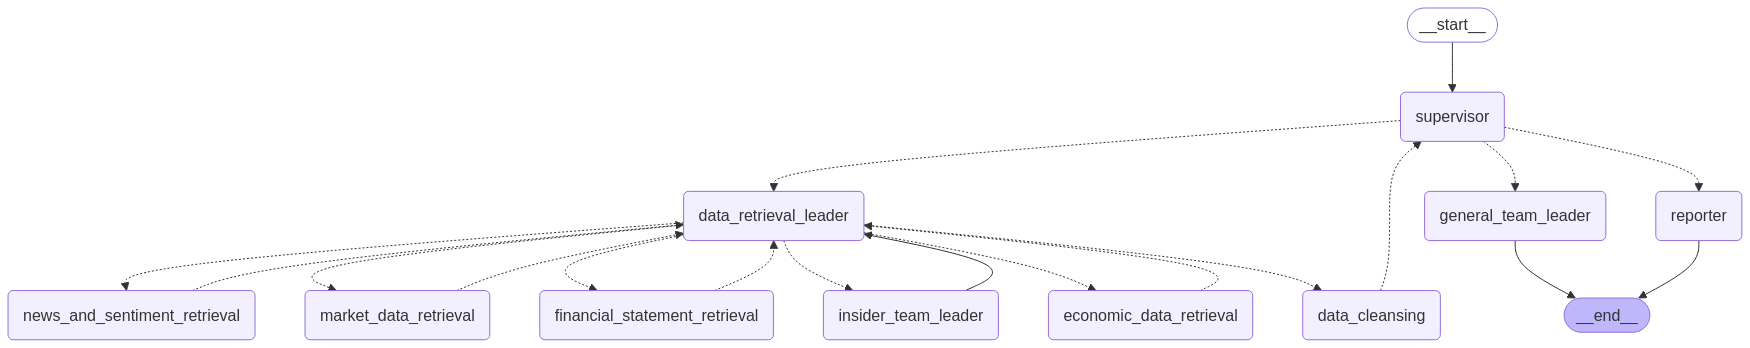

In [14]:
graph

In [17]:
query =  "김치찌개 만드는법"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

김치찌개 만드는법
================================== Ai Message ==================================

제공된 정보는 김치찌개 만드는 법에 대한 내용이 포함되어 있지 않습니다. 따라서, 이 질문에 대한 정확한 답변을 드릴 수 없습니다. 필요한 정보를 구체적으로 제시해 주시면 해당 부분에 대해 더 도움을 드릴 수 있습니다.


In [24]:
query =  "최근 내부자가 가장 많은 지분을 매수한 상장사는 어디야"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 내부자가 가장 많은 지분을 매수한 상장사는 어디야
200
================================ Human Message =================================
Name: insider_tracker_research

가장 최근에 내부자가 가장 많은 지분을 매수한 상장사는 다음과 같습니다:

1. **RENN Fund, Inc. (RCG)**
   - 내부자: **Murray Stahl** (회장 겸 CEO)
   - 매수 날짜: 2025-03-25
   - 매수한 주식 수: 1,084주 (여러 거래 포함)
   - 평균 가격: $2.61
   - 매수 후 소유 주식: 총 276,740주

2. **Community West Bancshares (CWBC)**
   - 내부자: **Dorothea D. Silva** (이사)
   - 매수 날짜: 2025-03-19
   - 매수한 주식 수: 56.7443주
   - 매수 가격: $18.26
   - 매수 후 소유 주식: 총 10,224.7443주

이 데이터는 최근 내부자 거래를 기준으로 하며, RCG에서 가장 많은 주식을 매수한 것으로 확인됩니다.
================================ Human Message =================================
Name: data_cleansing

가장 최근에 내부자가 가장 많은 지분을 매수한 상장사는 **RENN Fund, Inc. (RCG)**입니다. 내부자 **Murray Stahl**이 2025-03-25에 1,084주를 평균 $2.61에 매수했습니다.
================================== Ai Message ==================================

가장 최근에 내부자가 가장 많은 

In [18]:
query =  "하이"
for chunk in graph.stream(
    {"messages": [("human",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

하이
================================== Ai Message ==================================

안녕하세요! 어떻게 도와드릴까요?


In [20]:
query =  "너는 미국주식에 특화되어있냐"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

너는 미국주식에 특화되어있냐
================================== Ai Message ==================================

제공된 정보로는 제가 미국 주식에 특화되어 있는지에 대한 내용이 포함되어 있지 않습니다. 따라서 이 질문에 대한 명확한 답변을 드리기 어렵습니다. 추가적인 정보가 필요합니다.


In [18]:
query =  "무슨 질문에 대답할수있냐"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

무슨 질문에 대답할수있냐
================================ Human Message =================================

저는 미국 주식에 관한 다양한 질문에 답할 수 있습니다. 예를 들어, 특정 주식의 성과, SEC Filing 데이터, 경제 지표, 최근 뉴스 등과 관련된 정보를 제공하며, 투자 결정을 도울 수 있습니다.


In [21]:
query =  "너는 바보냐"
for chunk in graph.stream(
    {"messages": [("user",query)], "query" :query}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

너는 바보냐
================================== Ai Message ==================================

제공된 데이터에 따르면, 사용자 질문은 "너는 바보냐"입니다. 이 질문에 대한 정보는 충분하지 않으며, 답변할 수 있는 내용이 없습니다. 추가적인 정보를 요청하시면, 이에 대해 답변 드릴 수 있습니다.


In [16]:
for chunk in graph.stream(
    {"messages": [("user", "최근 한달간 테슬라 내부자 거래가 있었는지 확인해줘")]}, stream_mode="values"
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 한달간 테슬라 내부자 거래가 있었는지 확인해줘



KeyboardInterrupt



In [22]:
query= "오늘 테슬라 주가가 얼마냐"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

오늘 테슬라 주가가 얼마냐
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: market_data_retrieval

오늘 테슬라(TSLA)의 주가는 다음과 같습니다:

- 시가: 249.31 USD
- 고가: 260.56 USD
- 저가: 243.36 USD
- 종가: 259.16 USD
- 거래량: 133,450,000 주
================================ Human Message =================================
Name: data_cleansing

현재 테슬라(TSLA) 주가는 259.16 USD입니다.
================================== Ai Message ==================================

현재 테슬라(TSLA) 주가는 259.16 USD입니다.


In [15]:
query = "최근 테슬라 주가 흐름과 테슬라 주가에 영향을 주고있는 이슈를 찾아봐"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 테슬라 주가 흐름과 테슬라 주가에 영향을 주고있는 이슈를 찾아봐
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


================================ Human Message =================================
Name: market_data_retrieval

### 최근 테슬라 (TSLA) 주가 흐름

#### 1개월 (2025년 2월 28일 ~ 2025년 3월 28일)
- **종가 (Close)**
  - 2025-02-28: 292.98
  - 2025-03-03: 284.65
  - 2025-03-04: 272.04
  - 2025-03-05: 279.10
  - 2025-03-06: 263.45
  - 2025-03-07: 262.67
  - 2025-03-10: 222.15
  - 2025-03-11: 230.58
  - 2025-03-12: 248.09
  - 2025-03-13: 240.68
  - 2025-03-14: 249.98
  - 2025-03-17: 238.01
  - 2025-03-18: 225.31
  - 2025-03-19: 235.86
  - 2025-03-20: 236.26
  - 2025-03-21: 248.71
  - 2025-03-24: 278.39
  - 2025-03-25: 288.14
  - 2025-03-26: 272.06
  - 2025-03-27: 273.13
  - 2025-03-28: 263.55

- **최고가 (High)**
  - 2025-02-28: 293.88
  - 2025-03-03: 303.94
  - 2025-03-04: 284.35
  - 2025-03-05: 279.55
  - 2025-03-06: 272.65
  - 2025-03-07: 266.25
  - 2025-03-10: 253.37
  - 2025-03-11: 237.06
  - 2025-03-12: 251.84
  - 2025-03-13: 248.29
  - 2025-03-14: 251.58
  - 2025-03-17: 245.40
  - 2025-03-18: 230.10
  - 2025-

In [15]:
from pyexpat.errors import messages


query = "최근 테슬라 내부자 매도가 있었나?"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values", subgraphs=True):
    chunk[1]["messages"][-1].pretty_print()

================================ Human Message =================================

최근 테슬라 내부자 매도가 있었나?
================================ Human Message =================================

최근 테슬라 내부자 매도가 있었나?
================================ Human Message =================================

최근 테슬라 내부자 매도가 있었나?
================================== Ai Message ==================================
Tool Calls:
  fetch_filings_form3_4_5 (call_Hfp7ri8AmlC1BcA0yrp04bRV)
 Call ID: call_Hfp7ri8AmlC1BcA0yrp04bRV
  Args:
    ticker: TSLA
    transaction_type: S
    start_date: 2023-01-01
    end_date: 2025-04-01
200
================================= Tool Message =================================
Name: fetch_filings_form3_4_5

{"message": [{"accessionNo": "0001771340-25-000004", "filedAt": "2025-03-12", "periodOfReport": "2025-03-10", "documentType": "4", "issuer": {"name": "Tesla, Inc.", "tradingSymbol": "TSLA"}, "reportingOwner": {"name": "MURDOCH JAMES R", "relationship": {"isDirector": true, "isOfficer":

In [ ]:
query = "최근 테슬라 내부자 매도가 있었나?"
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근 테슬라 내부자 매도가 있었나?
200
================================ Human Message =================================
Name: international_insider_researcher

최근 테슬라(Tesla, Inc.)의 내부자 주식 매도 내역은 다음과 같습니다:

1. **James R. Murdoch**
   - **거래일**: 2025-03-10
   - **매도된 주식 수**: 54,776 주
   - **주당 가격**: $240.788
   - **남은 주식 수**: 477,011 주

2. **Vaibhav Taneja (CFO)**
   - **거래일**: 2025-03-06
   - **매도된 주식 수**: 약 2,672 주
   - **주당 가격**: $268.729
   - **남은 주식 수**: 26,949.5 주

3. **Vaibhav Taneja (CFO)**
   - **거래일**: 2025-03-03
   - **매도된 주식 수**: 총 2,931 주 (여러번의 트랜잭션 포함)
   - **주당 가격**: $296.194에서 $303.588 사이의 다양한 가격
   - **남은 주식 수**: 85,000 주

4. **Robyn M. Denholm**
   - **거래일**: 2025-03-03
   - **매도된 주식 수**: 총 112,390 주 (여러번의 트랜잭션 포함)
   - **주당 가격**: $292.310에서 $303.840 사이의 다양한 가격
   - **남은 주식 수**: 85,000 주

5. **Kimbal Musk**
   - **거래일**: 2025-02-06
   - **매도된 주식 수**: 74,077 주
   - **주당 가격**: $367.868
   - **남은 주식 수**: 1,

In [16]:
query = "테슬라에 대한 기관 투자자들의 보유 비중이 최근에 어떻게 변했는지 보고 싶어."
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

테슬라에 대한 기관 투자자들의 보유 비중이 최근에 어떻게 변했는지 보고 싶어.
200
================================ Human Message =================================
Name: international_insider_researcher

최근 테슬라(Tesla, Inc.)에 대한 주요 기관 투자자들의 보유 비중은 다음과 같습니다:

1. **Elon R. Musk**
   - **보유 비중**: 20.6% (2023-12-31 기준)
   - **총 보유 주식 수**: 715,022,706 주

2. **The Vanguard Group**
   - **보유 비중**: 7.23% (2023-12-29 기준)
   - **총 보유 주식 수**: 229,805,491 주

3. **BlackRock, Inc.**
   - **보유 비중**: 5.9% (2023-12-31 기준)
   - **총 보유 주식 수**: 188,797,465 주

이 데이터는 최근 2023년 내의 기관 투자자 보고서에 기반한 것입니다. 보유 비중의 변화에 대한 상세한 추적은 필요에 따라 추가 데이터 확보 및 분석이 가능할 수 있습니다.


In [17]:
query = "최근에 테슬라 대규모 지분을 확보하면서 경영 참여를 선언한 투자자가 있는지 알려줘."
for chunk in graph.stream(
    {"messages": [("user", query)], "query" : query}, stream_mode="values"
    ):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

최근에 테슬라 대규모 지분을 확보하면서 경영 참여를 선언한 투자자가 있는지 알려줘.
200
================================ Human Message =================================
Name: international_insider_researcher

최근 테슬라의 대규모 지분 확보와 관련하여 다음과 같은 주요 투자자의 보고서가 있습니다:

1. **The Vanguard Group, Inc.**
   - **보고서 유형**: SC 13G/A
   - **보고 날짜**: 2024-02-13
   - **이벤트 날짜**: 2023-12-29
   - **지분 비율**: 7.23%
   - **총 보유 주식 수**: 229,805,491 주
   - **독립 의결권**: 없음
   - **공동 의결권**: 3,719,744 주
   - **독립 결의권**: 217,847,966 주
   - **공동 결의권**: 11,957,525 주

2. **BlackRock, Inc.**
   - **보고서 유형**: SC 13G/A
   - **보고 날짜**: 2024-01-29
   - **이벤트 날짜**: 2023-12-31
   - **지분 비율**: 5.9%
   - **총 보유 주식 수**: 188,797,465 주
   - **독립 의결권**: 169,527,462 주
   - **공동 의결권**: 없음
   - **독립 결의권**: 188,797,465 주
   - **공동 결의권**: 없음

이 두 투자자는 최근 테슬라의 지분을 대규모로 확보하며 경영 참여 가능성을 시사하고 있습니다.
